In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob
# import Ngl
# import Nio 
# import metpy.calc as mpc
# from metpy.units import units

In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
## Function from Brian Medeiros to convert times to middle of period 
#  rather than the end of the averaging period. 

def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds


## Read in data for case study
Options include: 
* 'ARM97'
* 'ARM95' 
* '3month_summer2015'

In [4]:
iCase = '3month_summer2015'

if iCase=='3month_summer2015': 
    dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/wstar_tests/'

    # Define file names of cam history files
    hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HMG.3monthsFreeRunning.cam.h0.2015-05-31-84585.nc',
                              'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HMG.3monthsFreeRunning.cam.h0.2015-07-05-60585.nc',
                              'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HMG.3monthsFreeRunning.cam.h0.2015-08-09-36585.nc'])

    htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HTG.3monthsFreeRunning.cam.h0.2015-05-31-84585.nc',
                              'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HTG.3monthsFreeRunning.cam.h0.2015-07-05-60585.nc',
                              'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HTG.3monthsFreeRunning.cam.h0.2015-08-09-36585.nc'])

    # Define file names of clm history files 
    hmgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HMG.3monthsFreeRunning.clm2.h0.2015-05-31-84585.nc',
                              'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HMG.3monthsFreeRunning.clm2.h0.2015-07-05-60585.nc',
                              'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HMG.3monthsFreeRunning.clm2.h0.2015-08-09-36585.nc'])

    htgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HTG.3monthsFreeRunning.clm2.h0.2015-05-31-84585.nc',
                              'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HTG.3monthsFreeRunning.clm2.h0.2015-07-05-60585.nc',
                              'FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_HTG.3monthsFreeRunning.clm2.h0.2015-08-09-36585.nc'])

    
elif iCase=='ARM97':
    dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/'
    
    hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_ARM97.HMG.cam.h0.1997-06-18-84585.nc'])
    htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_ARM97.HTG.cam.h0.1997-06-18-84585.nc'])
    
    hmgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_ARM97.HMG.clm2.h0.1997-06-18-84585.nc'])
    htgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_ARM97.HTG.clm2.h0.1997-06-18-84585.nc'])
    
elif iCase=='ARM95':
    dataDir = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/FullyCoupledFromCTSM/'
    
    hmgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_ARM95.HMG.cam.h0.1995-07-18-19800.nc'])
    htgATMfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_ARM95.HTG.cam.h0.1995-07-18-19800.nc'])
    
    hmgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_ARM95.HMG.clm2.h0.1995-07-18-19800.nc'])
    htgLNDfiles = np.asarray(['FSCAM.T42_T42.CLASP_fullycoupled_FinalOption.onlyThlRt_ARM95.HTG.clm2.h0.1995-07-18-19800.nc'])
    
else:
    print('***** Not a valid experiment choice *****')
 

In [5]:
for iFile in range(len(hmgLNDfiles)): 
    
    with xr.open_dataset(dataDir+htgATMfiles[iFile], decode_times=False) as HTGcamDS:
        HTGcamDS = cesm_correct_time(HTGcamDS)
        HTGcamDS['time'] = HTGcamDS.indexes['time'].to_datetimeindex()
    with xr.open_dataset(dataDir+hmgATMfiles[iFile], decode_times=False) as HMGcamDS:
        HMGcamDS = cesm_correct_time(HMGcamDS)
        HMGcamDS['time'] = HMGcamDS.indexes['time'].to_datetimeindex()
        
    with xr.open_dataset(dataDir+htgLNDfiles[iFile], decode_times=True) as HTGclmDS:
        HTGclmDS['time'] = HTGcamDS.time
    with xr.open_dataset(dataDir+hmgLNDfiles[iFile], decode_times=True) as HMGclmDS:
        HMGclmDS['time'] = HMGcamDS.time
    
    if iFile==0:
        HTGcamDS_all = HTGcamDS 
        HMGcamDS_all = HMGcamDS
        HTGclmDS_all = HTGclmDS
        HMGclmDS_all = HMGclmDS 
    else: 
        HTGcamDS_all = xr.concat([HTGcamDS_all, HTGcamDS], dim='time')
        HMGcamDS_all = xr.concat([HMGcamDS_all, HMGcamDS], dim='time')
        HTGclmDS_all = xr.concat([HTGclmDS_all,HTGclmDS], dim='time', data_vars='minimal')
        HMGclmDS_all = xr.concat([HMGclmDS_all,HMGclmDS], dim='time', data_vars='minimal')
        
    print('Done reading in file %i of %i' % (iFile+1, len(hmgLNDfiles)))



Done reading in file 1 of 3
Done reading in file 2 of 3
Done reading in file 3 of 3


In [12]:
## Discard the first 2 days as spin up... 
iTimeStart   = np.where(HMGcamDS_all.time.values >= (HMGcamDS_all.time.values[0] + np.timedelta64(2,'D')))[0]
timeArr      = np.arange(iTimeStart[0], len(HMGcamDS_all.time.values))

HTGcamDS_all = HTGcamDS_all.isel(time=timeArr)
HTGclmDS_all = HTGclmDS_all.isel(time=timeArr)

HMGcamDS_all = HMGcamDS_all.isel(time=timeArr)
HMGclmDS_all = HMGclmDS_all.isel(time=timeArr)


## Timeseries plots

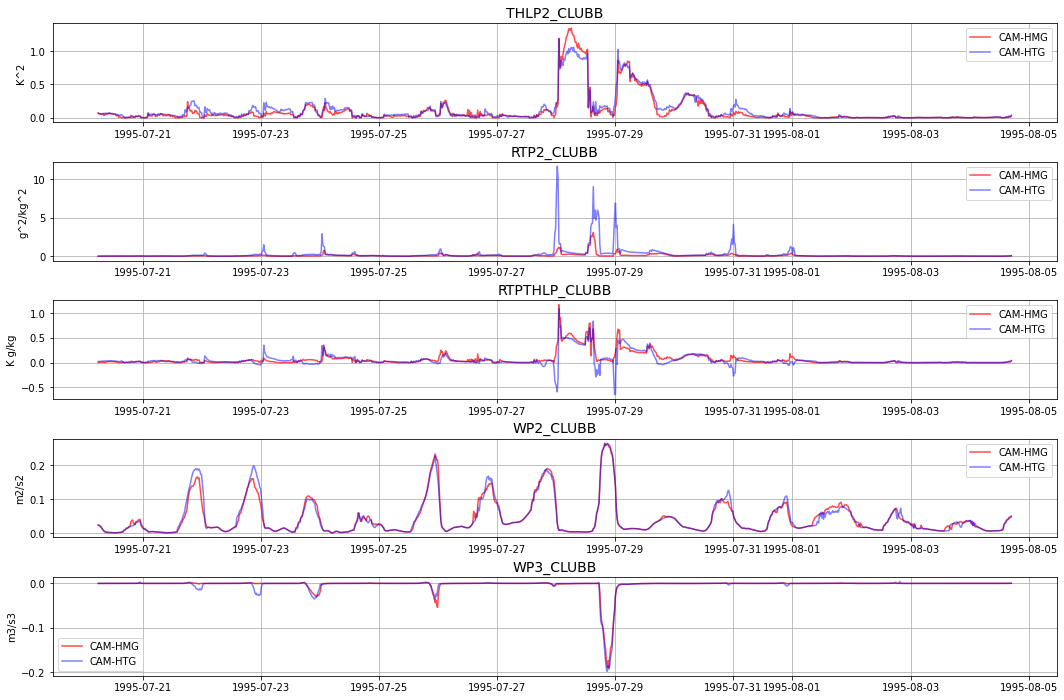

In [13]:
fig,axs = plt.subplots(5,1, figsize=(18,12))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WP2_CLUBB','WP3_CLUBB'])

for iVar in range(5):
    
    if ATM_varNames[iVar]=='WP3_CLUBB':
        axs[iVar].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all[ATM_varNames[iVar]].values[:,-2,:,:]),
                      'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all[ATM_varNames[iVar]].values[:,-2,:,:]),
                      'b-', alpha=0.5, label='CAM-HTG')        
    else:
        axs[iVar].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all[ATM_varNames[iVar]].values[:,-1,:,:]),
                      'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all[ATM_varNames[iVar]].values[:,-1,:,:]),
                      'b-', alpha=0.5, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units)
    axs[iVar].legend()
    axs[iVar].grid()
#     axs[iVar].set_xlim([datetime.date(2015,6,2), datetime.date(2015,8,29)])


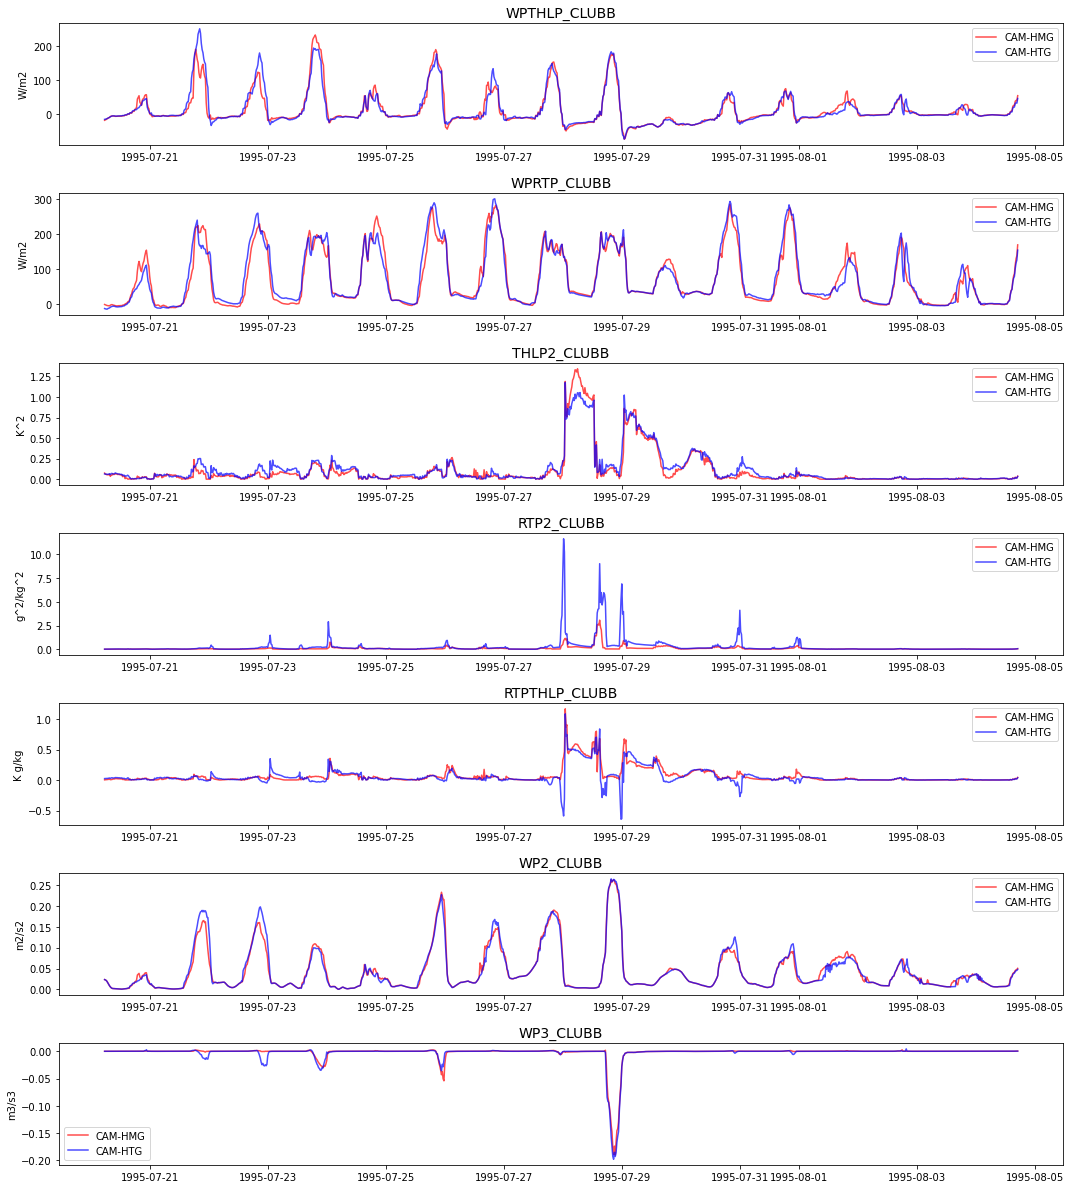

In [14]:
fig,axs = plt.subplots(7,1, figsize=(18,21))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

ATM_varNames = np.asarray(['WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','RTP2_CLUBB', 'RTPTHLP_CLUBB','WP2_CLUBB','WP3_CLUBB'])
# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(7):
        
    if ATM_varNames[iVar]=='WP3_CLUBB':
        axs[iVar].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all[ATM_varNames[iVar]].values)[:,-2],
                  'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all[ATM_varNames[iVar]].values)[:,-2],
                  'b-', alpha=0.7, label='CAM-HTG')
    else: 
        axs[iVar].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all[ATM_varNames[iVar]].values)[:,-1],
                      'r-', alpha=0.7, label='CAM-HMG')
        axs[iVar].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all[ATM_varNames[iVar]].values)[:,-1],
                      'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].set_ylabel(HMGcamDS_all[ATM_varNames[iVar]].units)
    axs[iVar].legend()
#     axs[iVar].set_xlim([datetime.date(2015,6,2), datetime.date(2015,8,29)])



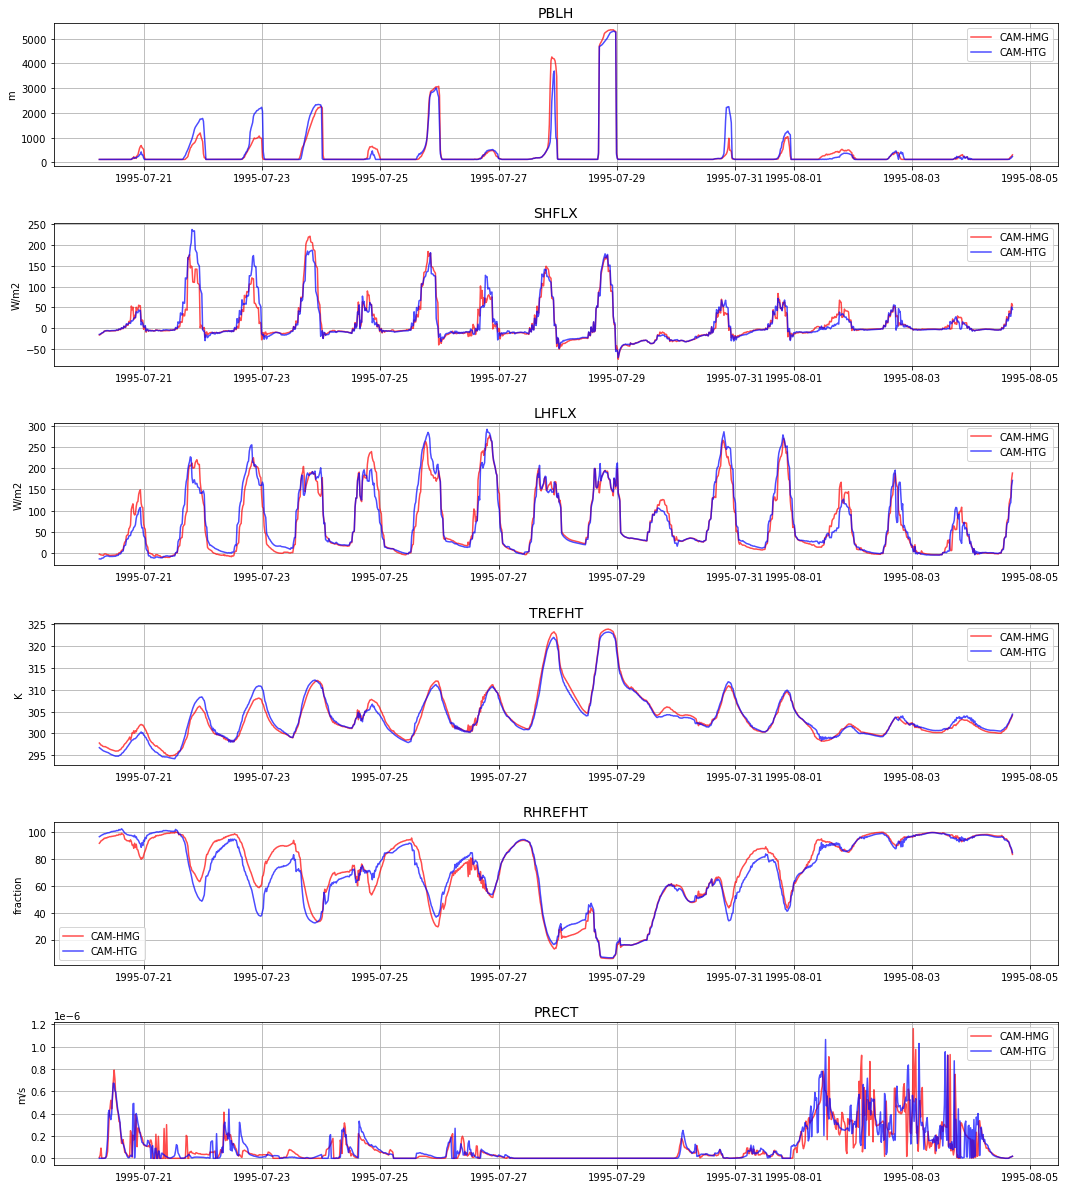

In [15]:
fig,axs = plt.subplots(6,1, figsize=(18,21))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

ATM_varNames = np.asarray(['PBLH','SHFLX','LHFLX','TREFHT','RHREFHT','PRECT'])
# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):
        
    axs[iVar].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iVar].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units)
    axs[iVar].legend()
    axs[iVar].grid()
#     axs[iVar].set_xlim([datetime.date(2015,6,3), datetime.date(2015,6,9)])

#     if ATM_varNames[iVar]=='SHFLX':
#         axs[iVar].set_ylim([-50,300])
#     elif ATM_varNames[iVar]=='LHFLX':
#         axs[iVar].set_ylim([-10,260])
#     elif ATM_varNames[iVar]=='TREFHT':
#         axs[iVar].set_ylim([270,310])
#     elif ATM_varNames[iVar]=='RHREFHT':
#         axs[iVar].set_ylim([10,120])




Text(0.5, 1.0, 'CLDHGH')

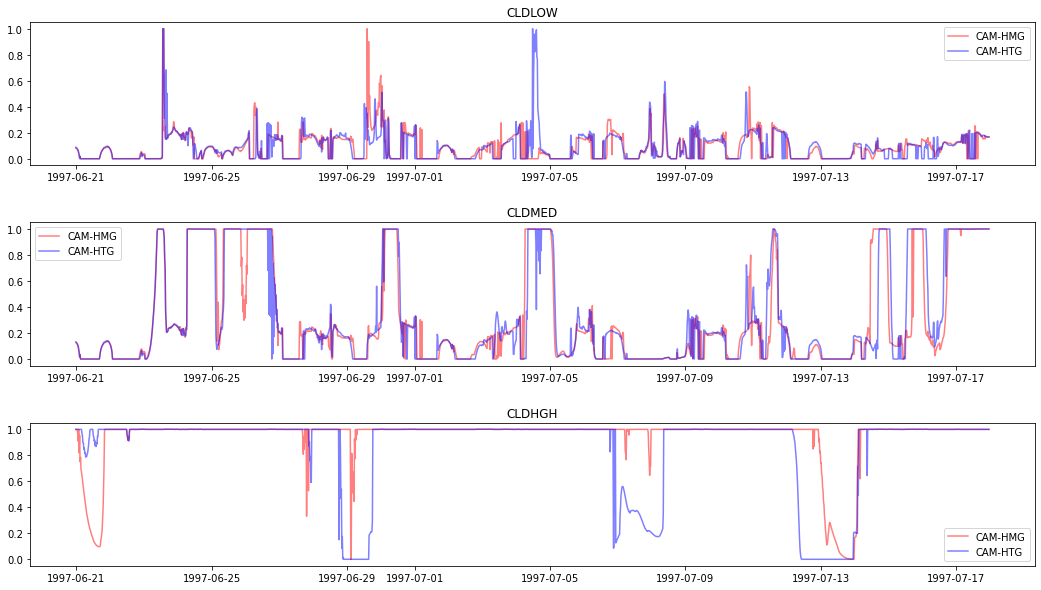

In [10]:
fig,axs = plt.subplots(3,1, figsize=(18,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

axs[0].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all.CLDLOW.values), 'r-', alpha=0.5, label='CAM-HMG')
axs[0].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all.CLDLOW.values), 'b-', alpha=0.5, label='CAM-HTG')
axs[0].legend()
axs[0].set_title('CLDLOW')

axs[1].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all.CLDMED.values), 'r-', alpha=0.5, label='CAM-HMG')
axs[1].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all.CLDMED.values), 'b-', alpha=0.5, label='CAM-HTG')
axs[1].legend()
axs[1].set_title('CLDMED')

axs[2].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all.CLDHGH.values), 'r-', alpha=0.5, label='CAM-HMG')
axs[2].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all.CLDHGH.values), 'b-', alpha=0.5, label='CAM-HTG')
axs[2].legend()
axs[2].set_title('CLDHGH')


Text(0.5, 1.0, 'U10')

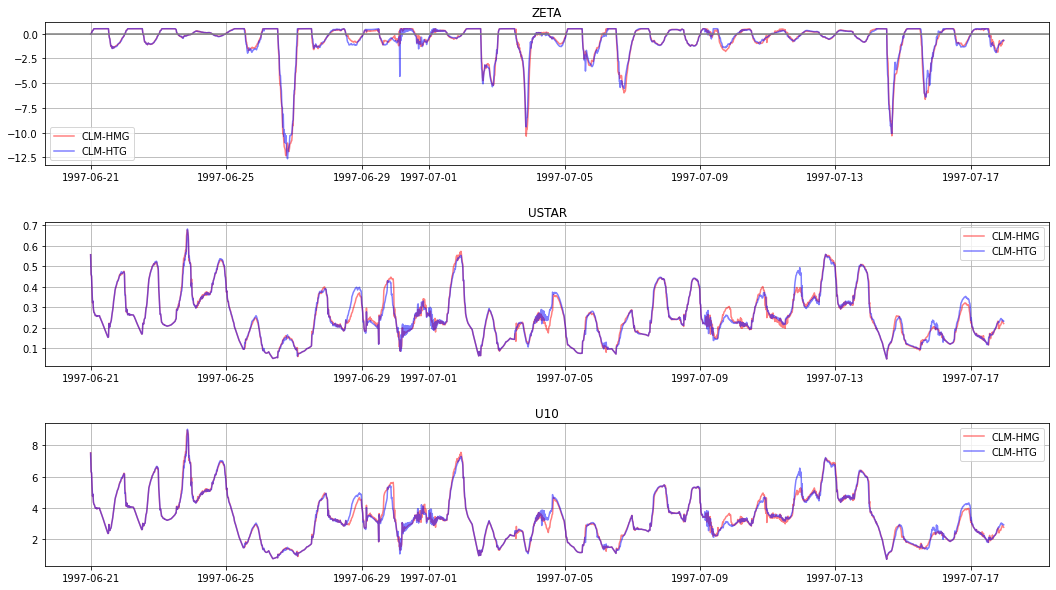

In [11]:
fig,axs = plt.subplots(3,1, figsize=(18,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

axs[0].plot(HMGclmDS_all['time'].values, np.squeeze(HMGclmDS_all.ZETA.values), 'r-', alpha=0.5, label='CLM-HMG')
axs[0].plot(HMGclmDS_all['time'].values, np.squeeze(HTGclmDS_all.ZETA.values), 'b-', alpha=0.5, label='CLM-HTG')
axs[0].legend()
axs[0].grid()
axs[0].axhline(0,color='grey')
axs[0].set_title('ZETA')
# axs[0].set_xlim([datetime.date(2015,6,2), datetime.date(2015,6,9)])

axs[1].plot(HMGclmDS_all['time'].values, np.squeeze(HMGclmDS_all.USTAR.values), 'r-', alpha=0.5, label='CLM-HMG')
axs[1].plot(HTGclmDS_all['time'].values, np.squeeze(HTGclmDS_all.USTAR.values), 'b-', alpha=0.5, label='CLM-HTG')
axs[1].legend()
axs[1].grid()
axs[1].set_title('USTAR')
# axs[1].set_xlim([datetime.date(2015,6,2), datetime.date(2015,6,9)])

axs[2].plot(HMGclmDS_all['time'].values, np.squeeze(HMGclmDS_all.U10.values), 'r-', alpha=0.5, label='CLM-HMG')
axs[2].plot(HTGclmDS_all['time'].values, np.squeeze(HTGclmDS_all.U10.values), 'b-', alpha=0.5, label='CLM-HTG')
axs[2].legend()
axs[2].grid()
axs[2].set_title('U10')
# axs[2].set_xlim([datetime.date(2015,6,2), datetime.date(2015,6,9)])



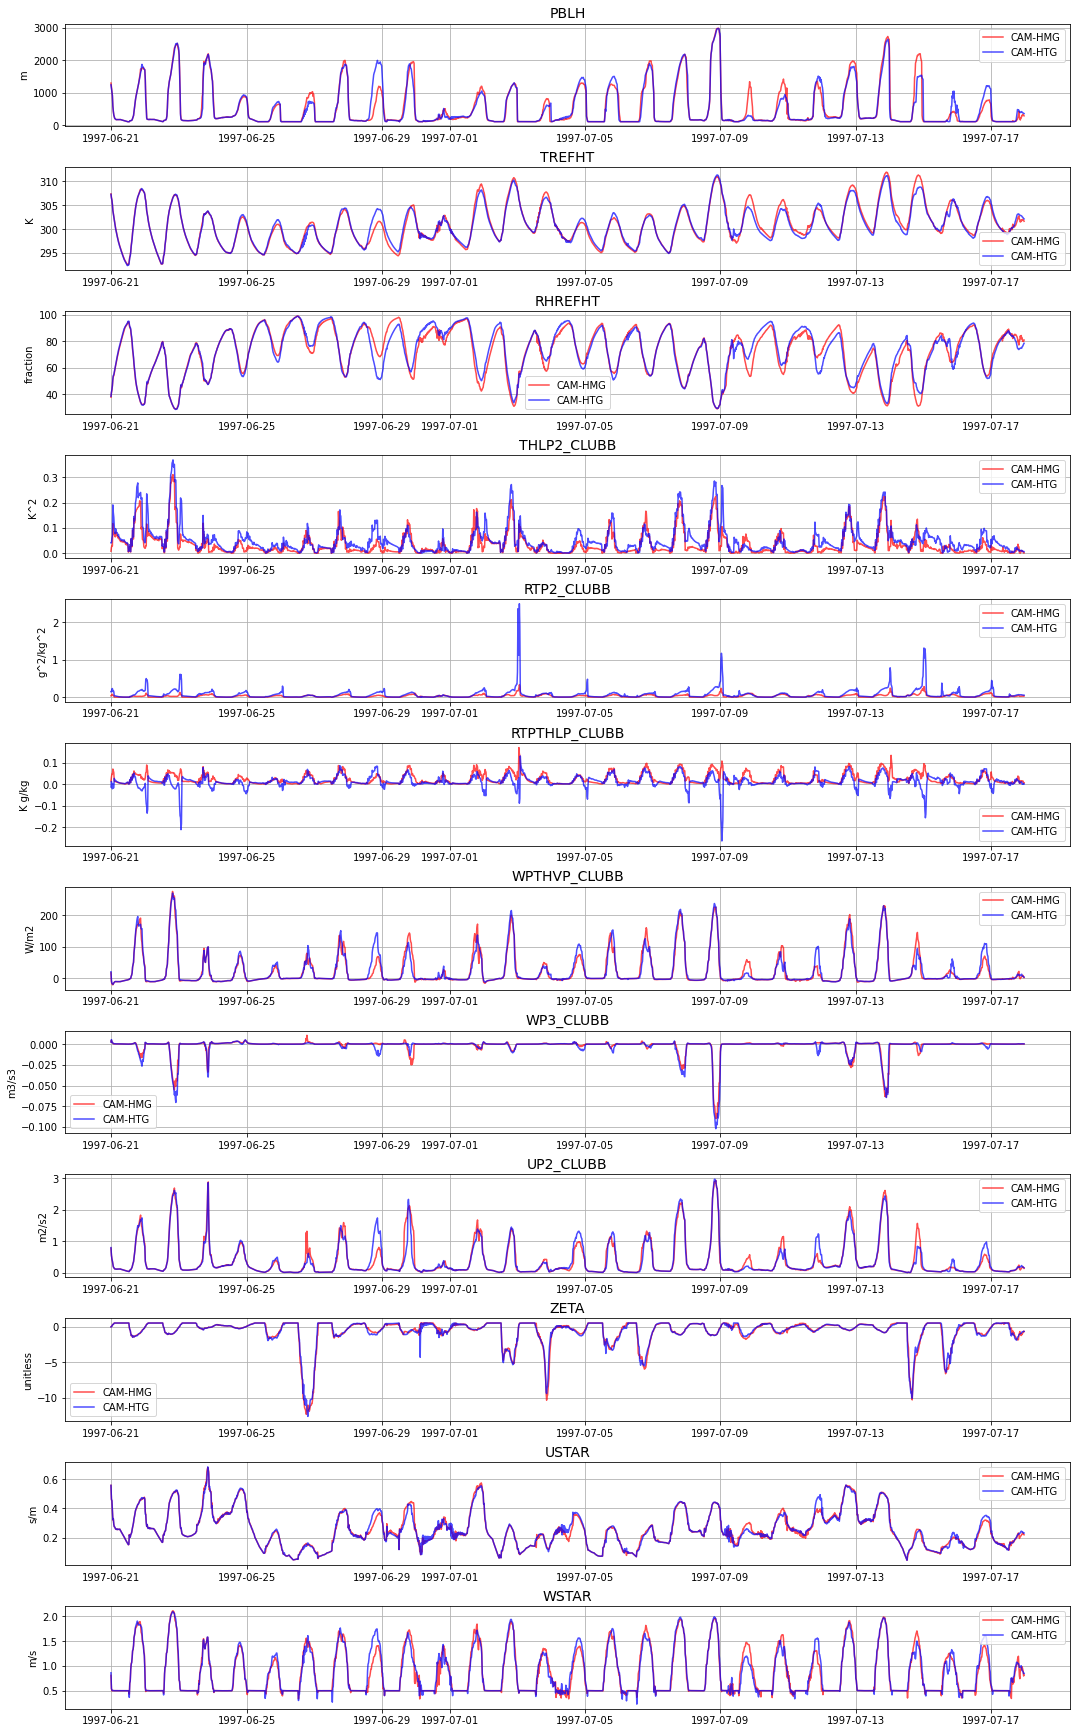

In [12]:
## Merge it all into one giant plot! 
## -----------------------------------------------------

# ATM_varNames   = np.asarray(['PBLH','SHFLX','LHFLX','PRECT'])
ATM_varNames   = np.asarray(['PBLH','TREFHT','RHREFHT'])

#ATM_varNames3D = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB'])
ATM_varNames3D = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPTHVP_CLUBB','WP3_CLUBB','UP2_CLUBB'])

# LND_varNames   = np.asarray(['ZETA','USTAR','U10'])
LND_varNames   = np.asarray(['ZETA','USTAR','WSTAR'])


nPlots = len(ATM_varNames)+len(ATM_varNames3D)+len(LND_varNames)
fig,axs = plt.subplots(nPlots,1, figsize=(18,31))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

# zoomWeek = 1
# full3mo  = 0 

# # When to start and end "zoomWeek" option
# startDate = datetime.date(2015,7,10)
# endDate   = datetime.date(2015,7,24)

for iVar in range(len(ATM_varNames)):
        
    axs[iVar].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all[ATM_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iVar].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all[ATM_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units)
    axs[iVar].legend()
    axs[iVar].grid()
#     if zoomWeek==1: 
#          axs[iVar].set_xlim([startDate, endDate])
#     elif full3mo==1: 
#         axs[iVar].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,29)])
#     else: 
#         axs[iVar].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,29)])


for iVar in range(len(ATM_varNames3D)):
    iPlt = iVar+len(ATM_varNames)
      
    if ATM_varNames3D[iVar]=='WP3_CLUBB':
        axs[iPlt].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all[ATM_varNames3D[iVar]].values)[:,-2],
                      'r-', alpha=0.7, label='CAM-HMG')
        axs[iPlt].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all[ATM_varNames3D[iVar]].values)[:,-2],
                      'b-', alpha=0.7, label='CAM-HTG')        
    else: 
        axs[iPlt].plot(HMGcamDS_all['time'].values, np.squeeze(HMGcamDS_all[ATM_varNames3D[iVar]].values)[:,-1],
                      'r-', alpha=0.7, label='CAM-HMG')
        axs[iPlt].plot(HTGcamDS_all['time'].values, np.squeeze(HTGcamDS_all[ATM_varNames3D[iVar]].values)[:,-1],
                      'b-', alpha=0.7, label='CAM-HTG')

    axs[iPlt].set_title(ATM_varNames3D[iVar],fontsize=14)
    axs[iPlt].set_ylabel(HMGcamDS[ATM_varNames3D[iVar]].units)
    axs[iPlt].legend()
    axs[iPlt].grid()
#     if zoomWeek==1: 
#          axs[iPlt].set_xlim([startDate, endDate])
#     elif full3mo==1: 
#         axs[iPlt].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,29)])
#     else: 
#         axs[iPlt].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,29)])
    
    
for iVar in range(len(LND_varNames)):
    iPlt = iVar+len(ATM_varNames)+len(ATM_varNames3D)
        
    axs[iPlt].plot(HMGclmDS_all['time'].values, np.squeeze(HMGclmDS_all[LND_varNames[iVar]].values),
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iPlt].plot(HTGclmDS_all['time'].values, np.squeeze(HTGclmDS_all[LND_varNames[iVar]].values),
                  'b-', alpha=0.7, label='CAM-HTG')

    axs[iPlt].set_title(LND_varNames[iVar],fontsize=14)
    axs[iPlt].set_ylabel(HMGclmDS[LND_varNames[iVar]].units)
    axs[iPlt].legend()
    axs[iPlt].grid()
#     if zoomWeek==1: 
#          axs[iPlt].set_xlim([startDate, endDate])
#     elif full3mo==1: 
#         axs[iPlt].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,29)])
#     else: 
#         axs[iPlt].set_xlim([datetime.date(2015,6,3), datetime.date(2015,8,29)]) 



## Try something new: scatter plots of differences

In [70]:
diff_UP2sfc      = HTGcamDS_all.UP2_CLUBB.values[:,-1,:,:] - HMGcamDS_all.UP2_CLUBB.values[:,-1,:,:]
diff_THLP2sfc    = HTGcamDS_all.THLP2_CLUBB.values[:,-1,:,:] - HMGcamDS_all.THLP2_CLUBB.values[:,-1,:,:]
diff_RTP2sfc     = HTGcamDS_all.RTP2_CLUBB.values[:,-1,:,:] - HMGcamDS_all.RTP2_CLUBB.values[:,-1,:,:]
diff_RTPTHLPsfc  = HTGcamDS_all.RTPTHLP_CLUBB.values[:,-1,:,:] - HMGcamDS_all.RTPTHLP_CLUBB.values[:,-1,:,:]
diff_WP3sfc      = HTGcamDS_all.WP3_CLUBB.values[:,-2,:,:] - HMGcamDS_all.WP3_CLUBB.values[:,-2,:,:]
diff_WPTHVPsfc   = HTGcamDS_all.WPTHVP_CLUBB.values[:,-1,:,:] - HMGcamDS_all.WPTHVP_CLUBB.values[:,-1,:,:]

diff_PBLH    = HTGcamDS_all.PBLH.values - HMGcamDS_all.PBLH.values
diff_RHrefht = HTGcamDS_all.RHREFHT.values - HMGcamDS_all.RHREFHT.values
diff_Trefht  = HTGcamDS_all.TREFHT.values - HMGcamDS_all.TREFHT.values
diff_CLDLOW  = HTGcamDS_all.CLDLOW.values - HMGcamDS_all.CLDLOW.values
diff_CLDTOT  = HTGcamDS_all.CLDTOT.values - HMGcamDS_all.CLDTOT.values
diff_CLDHGH  = HTGcamDS_all.CLDHGH.values - HMGcamDS_all.CLDHGH.values

diff_wstar  = HTGclmDS_all.WSTAR.values - HMGclmDS_all.WSTAR.values
diff_ustar  = HTGclmDS_all.USTAR.values - HMGclmDS_all.USTAR.values
diff_zeta   = HTGclmDS_all.ZETA.values  - HMGclmDS_all.ZETA.values

Text(0.05, 0.92, 'CorrCoef = -0.1314063048676012')

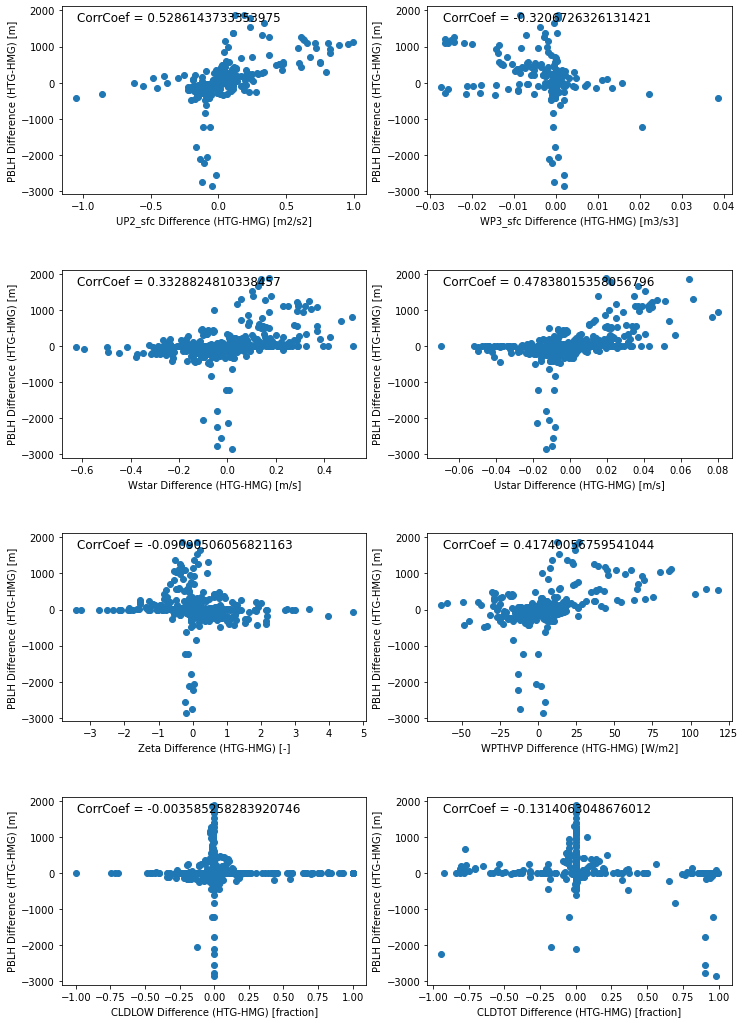

In [75]:
fig,axs = plt.subplots(4,2, figsize=(12,18))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.4)

# PBLH vs. UP2sfc
axs[0].scatter(diff_UP2sfc,diff_PBLH)
axs[0].set_xlabel('UP2_sfc Difference (HTG-HMG) [m2/s2]')
axs[0].set_ylabel('PBLH Difference (HTG-HMG) [m]')
axs[0].text(0.05,0.92,'CorrCoef = '+str(np.corrcoef(np.squeeze(diff_UP2sfc), np.squeeze(diff_PBLH))[1,0]),
            transform=axs[0].transAxes, fontsize=12)

# PBLH vs. WP3
axs[1].scatter(diff_WP3sfc,diff_PBLH)
axs[1].set_xlabel('WP3_sfc Difference (HTG-HMG) [m3/s3]')
axs[1].set_ylabel('PBLH Difference (HTG-HMG) [m]')
axs[1].text(0.05,0.92,'CorrCoef = '+str(np.corrcoef(np.squeeze(diff_WP3sfc), np.squeeze(diff_PBLH))[1,0]),
            transform=axs[1].transAxes, fontsize=12)

# PBLH vs. WSTAR
axs[2].scatter(diff_wstar,diff_PBLH)
axs[2].set_xlabel('Wstar Difference (HTG-HMG) [m/s]')
axs[2].set_ylabel('PBLH Difference (HTG-HMG) [m]')
axs[2].text(0.05,0.92,'CorrCoef = '+str(np.corrcoef(np.squeeze(diff_wstar), np.squeeze(diff_PBLH))[1,0]),
            transform=axs[2].transAxes, fontsize=12)

# PBLH vs. USTAR
axs[3].scatter(diff_ustar,diff_PBLH)
axs[3].set_xlabel('Ustar Difference (HTG-HMG) [m/s]')
axs[3].set_ylabel('PBLH Difference (HTG-HMG) [m]')
axs[3].text(0.05,0.92,'CorrCoef = '+str(np.corrcoef(np.squeeze(diff_ustar), np.squeeze(diff_PBLH))[1,0]),
            transform=axs[3].transAxes, fontsize=12)

# PBLH vs. ZETA
axs[4].scatter(diff_zeta,diff_PBLH)
axs[4].set_xlabel('Zeta Difference (HTG-HMG) [-]')
axs[4].set_ylabel('PBLH Difference (HTG-HMG) [m]')
axs[4].text(0.05,0.92,'CorrCoef = '+str(np.corrcoef(np.squeeze(diff_zeta), np.squeeze(diff_PBLH))[1,0]),
            transform=axs[4].transAxes, fontsize=12)

# PBLH vs. WPTHVP
axs[5].scatter(diff_WPTHVPsfc,diff_PBLH)
axs[5].set_xlabel('WPTHVP Difference (HTG-HMG) [W/m2]')
axs[5].set_ylabel('PBLH Difference (HTG-HMG) [m]')
axs[5].text(0.05,0.92,'CorrCoef = '+str(np.corrcoef(np.squeeze(diff_WPTHVPsfc), np.squeeze(diff_PBLH))[1,0]),
            transform=axs[5].transAxes, fontsize=12)

# PBLH vs. CLDLOW
axs[6].scatter(diff_CLDLOW,diff_PBLH)
axs[6].set_xlabel('CLDLOW Difference (HTG-HMG) [fraction]')
axs[6].set_ylabel('PBLH Difference (HTG-HMG) [m]')
axs[6].text(0.05,0.92,'CorrCoef = '+str(np.corrcoef(np.squeeze(diff_CLDLOW), np.squeeze(diff_PBLH))[1,0]),
            transform=axs[6].transAxes, fontsize=12)

# PBLH vs. CLDTOT
axs[7].scatter(diff_CLDTOT,diff_PBLH)
axs[7].set_xlabel('CLDTOT Difference (HTG-HMG) [fraction]')
axs[7].set_ylabel('PBLH Difference (HTG-HMG) [m]')
axs[7].text(0.05,0.92,'CorrCoef = '+str(np.corrcoef(np.squeeze(diff_CLDTOT), np.squeeze(diff_PBLH))[1,0]),
            transform=axs[7].transAxes, fontsize=12)


## Mean diurnal cycles

In [7]:
# Get means a function of hour of day
hourlyMean_HMG = HMGcamDS_all.groupby("time.hour").mean()
hourlyMean_HTG = HTGcamDS_all.groupby("time.hour").mean()

hourlyMean_HMG['TBOT'] = (('time','lat','lon'), hourlyMean_HMG.T.values[:,-1,:,:])
hourlyMean_HTG['TBOT'] = (('time','lat','lon'), hourlyMean_HTG.T.values[:,-1,:,:])

hourlyMean_HMG['TBOT'].attrs['units'] = 'K'
hourlyMean_HTG['TBOT'].attrs['units'] = 'K'


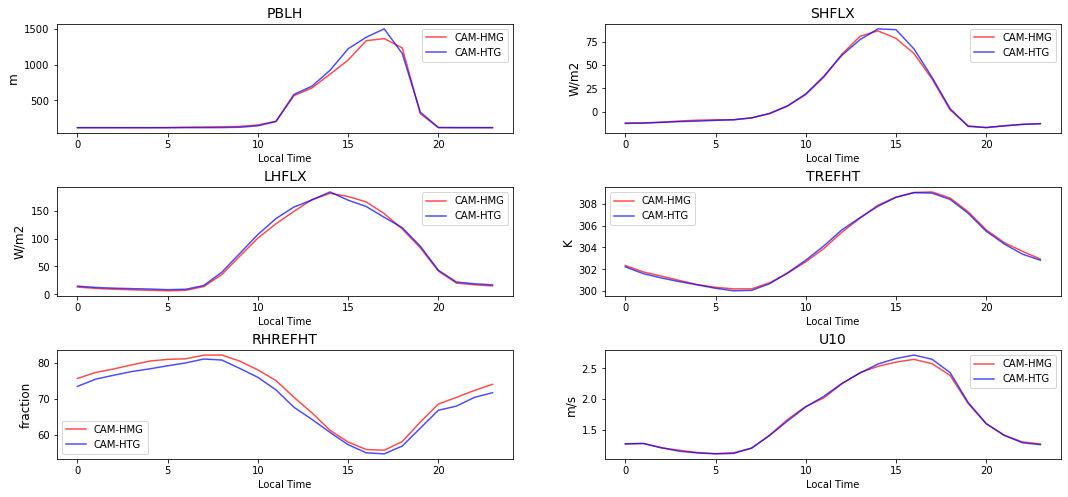

In [8]:
fig,axs = plt.subplots(3,2, figsize=(18,8))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['PBLH','SHFLX','LHFLX','TREFHT','RHREFHT','U10'])
# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(6):
    # Make it show in local time 
    doubleVar_HMG = np.concatenate([np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values)[:],np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values)[:]])
    doubleVar_HTG = np.concatenate([np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values)[:],np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values)[:]])
    doubleHour    = np.concatenate([hourlyMean_HMG['hour'].values-5,hourlyMean_HMG['hour'].values-5+24])
       
    axs[iVar].plot(doubleHour[5:29], doubleVar_HMG[5:29],
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iVar].plot(doubleHour[5:29], doubleVar_HTG[5:29],
                  'b-', alpha=0.7, label='CAM-HTG')
    
#     axs[iVar].plot(hourlyMean_HMG['hour'].values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values),
#                   'r-', alpha=0.7, label='CAM-HMG')
#     axs[iVar].plot(hourlyMean_HTG['hour'].values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values),
#                   'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    
    if ATM_varNames[iVar]!='TBOT':
        axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units, fontsize=12)
    else:
        axs[iVar].set_ylabel(HMGcamDS['T'].units, fontsize=12)
        

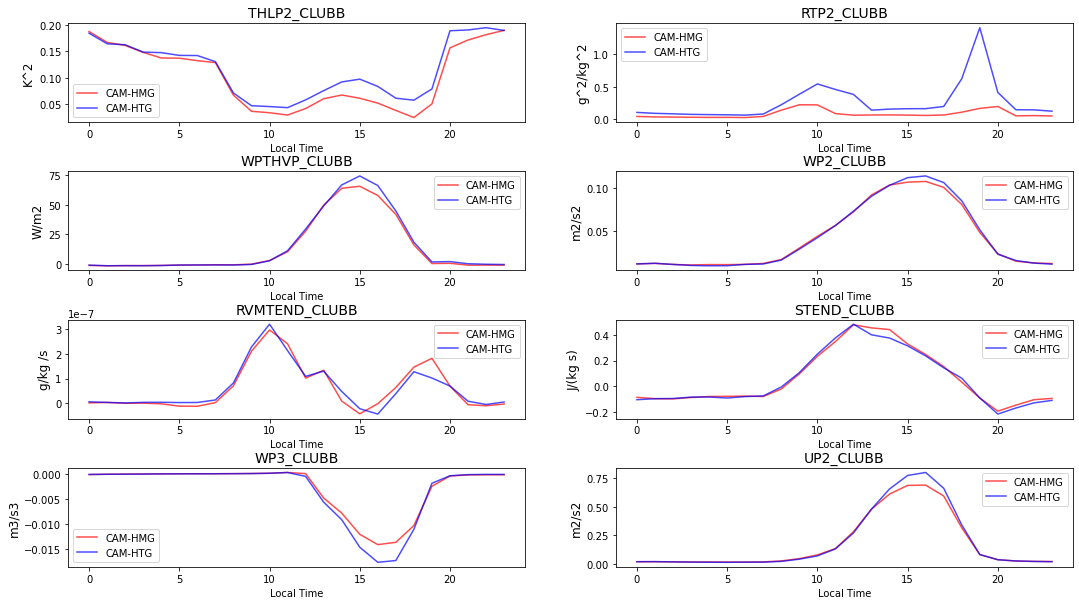

In [9]:
fig,axs = plt.subplots(4,2, figsize=(18,10))
axs = axs.ravel()
fig.subplots_adjust(hspace=0.5)

ATM_varNames = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','WPTHVP_CLUBB','WP2_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','WP3_CLUBB','UP2_CLUBB'])
# LND_varNames = np.asarray(['THLP2_CLUBB','QP2_CLUBB','UP2_CLUBB','WP2_CLUBB','WP3_CLUBB','WP4_CLUBB'])

for iVar in range(8):
    # Make it show in local time 
    if ATM_varNames[iVar]!='WP3_CLUBB':
        doubleVar_HMG = np.concatenate([np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values)[:,-1],np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values)[:,-1]])
        doubleVar_HTG = np.concatenate([np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values)[:,-1],np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values)[:,-1]])
    else: 
        doubleVar_HMG = np.concatenate([np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values)[:,-2],np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values)[:,-2]])
        doubleVar_HTG = np.concatenate([np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values)[:,-2],np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values)[:,-2]])


    doubleHour    = np.concatenate([hourlyMean_HMG['hour'].values-5,hourlyMean_HMG['hour'].values-5+24])
       
    axs[iVar].plot(doubleHour[5:29], doubleVar_HMG[5:29],
                  'r-', alpha=0.7, label='CAM-HMG')
    axs[iVar].plot(doubleHour[5:29], doubleVar_HTG[5:29],
                  'b-', alpha=0.7, label='CAM-HTG')
    
#     axs[iVar].plot(hourlyMean_HMG['hour'].values, np.squeeze(hourlyMean_HMG[ATM_varNames[iVar]].values),
#                   'r-', alpha=0.7, label='CAM-HMG')
#     axs[iVar].plot(hourlyMean_HTG['hour'].values, np.squeeze(hourlyMean_HTG[ATM_varNames[iVar]].values),
#                   'b-', alpha=0.7, label='CAM-HTG')

    axs[iVar].set_title(ATM_varNames[iVar],fontsize=14)
    axs[iVar].legend()
    axs[iVar].set_xlabel('Local Time')
    
    if ATM_varNames[iVar]!='TBOT':
        axs[iVar].set_ylabel(HMGcamDS[ATM_varNames[iVar]].units, fontsize=12)
    else:
        axs[iVar].set_ylabel(HMGcamDS['T'].units, fontsize=12)
        